In [128]:
# import des bibliothèques utilisées
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pingouin as pg
import sklearn
from sklearn.datasets import make_regression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import *
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import set_config
set_config(display='diagram')

# I. Chargement et contrôle des données

In [129]:
df = pd.read_csv("building-energy-cleaned.csv")
print(df.columns)
print(df.shape)
df.head()

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'Latitude', 'Longitude',
       'PropertyGFATotal', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'GFABuildingRate',
       'GFAParkingRate', 'GFA_Volume_Building', 'GFA_Building', 'GFA_Floor',
       'Age'],
      dtype='object')
(1638, 20)


,BuildingType,PrimaryPropertyType,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,Latitude,Longitude,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,GFABuildingRate,GFAParkingRate,GFA_Volume_Building,GFA_Building,GFA_Floor,Age
0,NonResidential,Supermarket/Store,Downtown,0,Unknown,N.C.,47.611711,-122.336816,111077.0,0.0,0.0,91.0,9898724.0,69.01,1.00000,0.00000,444308.0,111077.0,27769.250,26
1,NonResidential,Small- and Mid-Sized Office,Downtown,Office,Office,N.C.,47.606799,-122.337100,98370.0,98370.0,0.0,45.0,6525887.0,47.24,0.73651,0.26349,434700.0,98370.0,16395.000,109
2,NonResidential,Large Office,Lake union,"Data Center, Office, Other, Parking, Restaurant",Office,Parking,47.621476,-122.343050,193788.0,138672.0,47539.0,59.0,16760217.0,116.84,0.80466,0.19534,623736.0,193788.0,48447.000,68
3,NonResidential,Small- and Mid-Sized Office,Greater duwamish,"Office, Parking",Office,Parking,47.570897,-122.297412,76598.0,55188.0,21410.0,76.0,4476997.0,134.69,0.72049,0.27951,165564.0,76598.0,25532.667,7
4,NonResidential,Large Office,Lake union,"Office, Parking",Office,Parking,47.621243,-122.329786,186971.0,186977.0,115477.0,86.0,12662456.0,226.92,1.00000,0.00000,747884.0,186971.0,46742.750,34


In [130]:
upper_limit = df['SiteEnergyUse(kBtu)'].quantile(0.98)
df = df[df['SiteEnergyUse(kBtu)'] < upper_limit]

<AxesSubplot:>

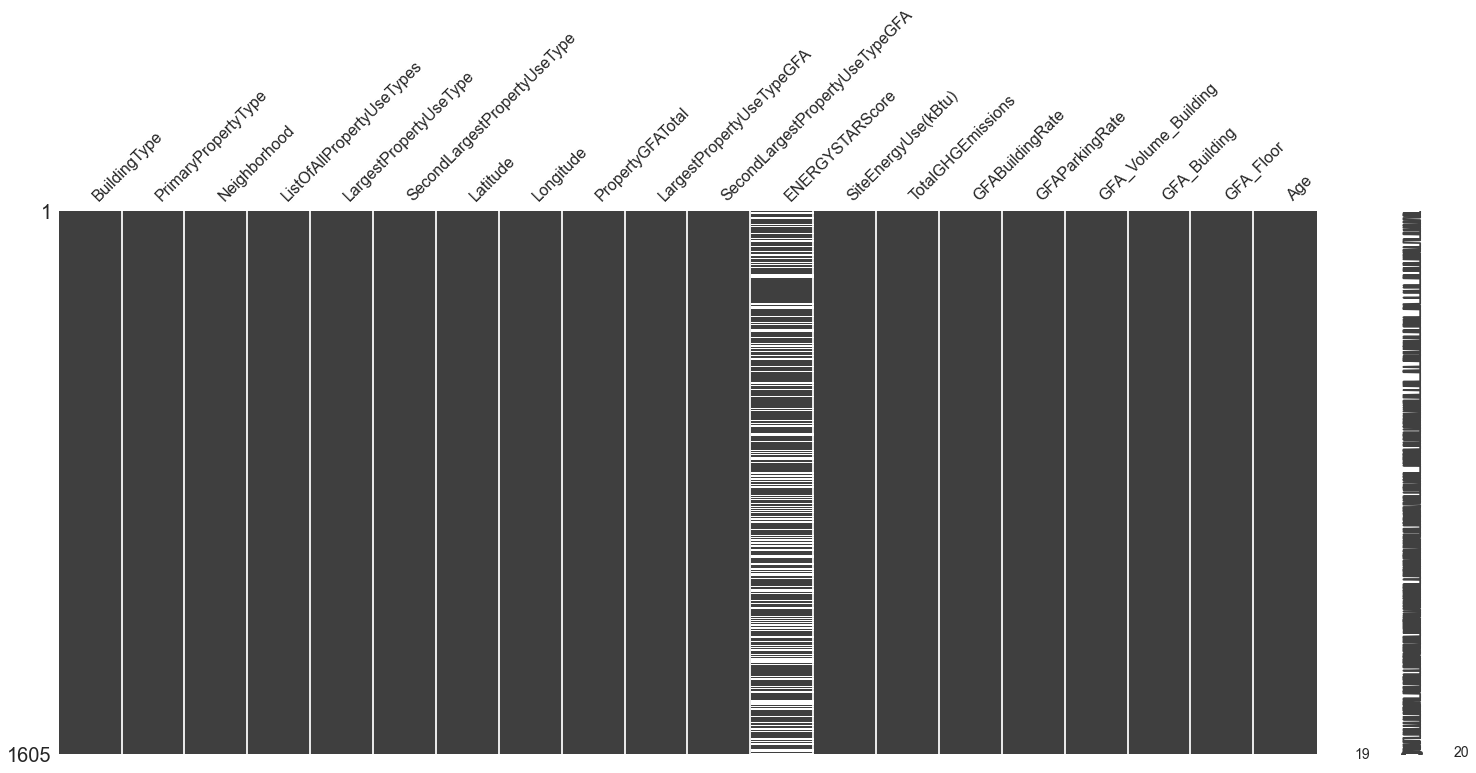

In [131]:
msno.matrix(df)

# II. Modeling et analyse la variable 'SiteEnergyUse(kBtu)'  à prédire

 Le score ENERGYSTAR va supprimer parceque on ne va pas s'en servir pour prédire la consommation d'énergie, On le garde dans energy_star_score  afin de vérifier ensuite si cette variable a un impact sur la qualité de prédiction.

In [132]:
energy_star_score = df[['ENERGYSTARScore']]

df = df.drop(["ENERGYSTARScore","TotalGHGEmissions","GFA_Volume_Building", "GFA_Building", "GFA_Floor"], axis=1)


## Encoding et standardisation
Pour les variables catégorielles : On les transforme via un OneHotEncoding. Ainsi, elles seront transformées en valeur numérique compréhensible par notre modèles.

Pour les variables numériques : On standardise nos variables pour enlever les unités qui sont différents.



In [133]:
# on remet à jour la liste des colonnes catégorielles
# Séparation des variables catégorielles et numériques
num_var = df.select_dtypes(include=['int64','float64'])
cat_var = df.select_dtypes(exclude=['int64','float64']) 
print(cat_var.columns.tolist())
print('='*100)
print(num_var.columns.tolist())


df_model = pd.concat([cat_var, num_var], axis=1)



['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']
['Latitude', 'Longitude', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)', 'GFABuildingRate', 'GFAParkingRate', 'Age']


In [134]:
# Séparation des variables catégorielles et numériques
cat_var = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']
num_var = ['Latitude', 'Longitude', 'PropertyGFATotal', 
           'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'GFABuildingRate', 'GFAParkingRate','Age']


In [135]:
# Création d'un pipeline de transformation

cat_pipe = Pipeline([ ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
                      ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy="median", fill_value="missing")), 
                     ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, cat_var), ('num', num_pipe, num_var)])


On va séparer notre jeu de données en deux parties : un train set et un test set. On ne va pas toucher aux données du test set car il nous servia pour la validation de notre modèle. C'est grâce à ce jeu de données que l'on pourra sortir les metrics nécessaires. Dans chaque jeu (entraînement et test), on supprime les variables qui ne seront pas utiles dans notre modélisation. Tout d'abord,On supprime les variables que l'on cherche à prédire. "SiteEnergyUse(kBtu)" est la cible que l'on cherche à prédire, On ne travaillera que sur la colonne "SiteEnergyUse(kBtu)s et on le mettra donc dans une variable y.

In [136]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
objectColumns = list(df_model.dtypes[df_model.dtypes == object].index)
numericColumns = list(df_model.dtypes[df_model.dtypes != object].index)

X = df.drop('SiteEnergyUse(kBtu)', axis=1)
y = df['SiteEnergyUse(kBtu)']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# transformation des variables
X_train = preprocessor.fit_transform(X_train)

Afin de définir le meilleur modèle prédictif dans le cadre de notre projet, nous utiliserons des métriques de notation pour chaque modèle. Nous utilisons des modèles de régression pour prédire notre sortie car nous travaillons avec des données continues.

L'Erreur quadratique moyenne, l'Erreur absolue moyenne, l'Erreur quadratique moyenne et les métriques R-carré ou Coefficient de détermination sont utilisées pour évaluer les performances du modèle dans l'analyse de régression.

L'erreur absolue moyenne représente la moyenne de la différence absolue entre les valeurs réelles et prédites dans l'ensemble de données. Il mesure la moyenne des résidus dans l'ensemble de données.

En plus, on applique la transformation dans notre pipeline grâce à la fonction TransformedTargetRegressor 

In [137]:
models = {
    'Dummy Regressor' : DummyRegressor(strategy="median"),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'DecisionTree' : DecisionTreeRegressor(random_state=42),
    'ElasticNet' : ElasticNet(),
    'SVR': SVR(),
    'Ridge Kernel' : KernelRidge(),
    'RandomForestRegressor' : RandomForestRegressor(random_state=42),
    'XGBRegressor' : XGBRegressor()
}
 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [138]:
results_model = []
#parametres = []
for model_name, model in models.items():
    # Model preprocessor avec pipeline
    model = make_pipeline(preprocessor,model)
    
    # Fit models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluer les performances du modèles avec les métriques
    print(f"Evaluer la performance {model_name}...")
    mae = mean_absolute_error(y_test, y_pred).round(3)
    mse = mean_squared_error(y_test, y_pred).round(3)
    rmse = np.sqrt(mse).round(3)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    med_abs_err = median_absolute_error(y_test,y_pred).round(3)
    print("MAE = ", mae)        
    print("MSE = ", mse)
    print("RMSE = ",rmse)
    print("R² = ", r_score)
    print("median abs err = ", med_abs_err)
    print('-'*100)
    # Score model et  append model results dict avec valeurs
    results_model.append([model_name, mae, mse, rmse, r_score, med_abs_err])
    


Evaluer la performance Dummy Regressor...
MAE =  3745887.344
MSE =  47477182623103.49
RMSE =  6890368.831
R² =  -0.13
median abs err =  1561839.344
----------------------------------------------------------------------------------------------------
Evaluer la performance Ridge...
MAE =  2211600.62
MSE =  13267123728505.248
RMSE =  3642406.31
R² =  0.684
median abs err =  1211141.366
----------------------------------------------------------------------------------------------------
Evaluer la performance Lasso...
MAE =  2372713.774
MSE =  15418686837035.52
RMSE =  3926663.576
R² =  0.633
median abs err =  1411542.564
----------------------------------------------------------------------------------------------------
Evaluer la performance DecisionTree...
MAE =  2462189.335
MSE =  18731899540391.594
RMSE =  4328036.453
R² =  0.554
median abs err =  1096343.625
----------------------------------------------------------------------------------------------------
Evaluer la performance Elas

In [123]:
model_score_eval = pd.DataFrame(results_model,columns=['model', 'MAE', 'MSE', 'RMSE', 'R²', 'median abs err'])

model_score_eval

,model,MAE,MSE,RMSE,R²,median abs err
0,Dummy Regressor,3745887.344,4.747718e+13,6890368.831,-0.130,1561839.344
1,Ridge,2211600.620,1.326712e+13,3642406.310,0.684,1211141.366
2,Lasso,2372713.774,1.541869e+13,3926663.576,0.633,1411542.564
3,DecisionTree,2462189.335,1.873190e+13,4328036.453,0.554,1096343.625
4,ElasticNet,2610599.245,1.627664e+13,4034431.828,0.613,1795058.649
5,SVR,3745870.501,4.747682e+13,6890342.674,-0.130,1561853.529
6,Ridge Kernel,2217364.313,1.333549e+13,3651778.502,0.683,1195314.239
7,RandomForestRegressor,1872395.903,1.075487e+13,3279461.517,0.744,800027.973
8,XGBRegressor,1862489.747,1.010788e+13,3179289.566,0.759,861263.500


# Recherche des hyperparamètres avec GridSearchCV

On ajoute d'une validation croisée pour diminuer les risques d'overfitting.On recherche des hyperparamètres avec GridSearchCV en précisant les métriques de scoring (MAE : Mean Absolute Error. R² : Coeficient de détermination, carré du coefiscient de corrélation linéaire.)
On va utiliser le mean_test_score pour estimer la performance et la base de test final pour estimer la performance également et après on va sélectionner le meilleur modèle, donc d'abord on va créer un modèle baseline régression linéaire multivariée pour évaluer les performances de nos modèles

 On va affiner les hyperparamètres afin d'obtenir la meilleure performance pour notres modèles.
 Afin de trouver des hyperparamètres les plus adaptés on va faire une recherche via une SearchGrid(On ajoute d'une validation croisée pour diminuer les risques d'overfitting(k = 5)).

## Modèle Baseline : Régression linéaire multivariée

On crée un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu'ils améliore les prédictions. Pour cette baseline, nous utiliserons une régression linéaire multivariée.

In [14]:
results_gridSearch = []

# Recherche de la meilleure configuration d'hyperparamètre
model = make_pipeline(preprocessor,LinearRegression())

parameters_MLR = {'linearregression__fit_intercept':[True,False],  
                  'linearregression__copy_X':[True, False]
                 }

MLR_gridSearch = GridSearchCV(model, parameters_MLR, cv=5, n_jobs = 5)

MLR_gridSearch.fit(X_train, y_train.values.ravel())
y_pred_MLR = MLR_gridSearch.predict(X_test)

print('Best score et params LinearRegression')
print ("best score: ", MLR_gridSearch.best_score_)
print("best params: ",MLR_gridSearch.best_params_)
print('mean_fit_time :', MLR_gridSearch.cv_results_['mean_fit_time'])
print('mean_score_time :', MLR_gridSearch.cv_results_['mean_score_time'])
#print('mean_train_score :' , MLR_gridSearch.cv_results_['mean_train_score'])
print('mean_test_score :',MLR_gridSearch.cv_results_['mean_test_score'])
print('-'*50)
print("score de la prédiction LinearRegression:")
mae = mean_absolute_error(y_test,y_pred_MLR).round(3)
mse = mean_squared_error(y_test,y_pred_MLR).round(3)
r_score = r2_score(y_test, y_pred_MLR, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_MLR)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_MLR).round(3)
print("MAE = ",mae)
print("MSE = ", mse)
print("RMSE = ",rmse)
print("R² = ", r_score)
print("median abs err = ",med_abs_err)

results_gridSearch.append(['LinearRegression',
                          MLR_gridSearch.best_score_,
                          MLR_gridSearch.best_params_,
                          MLR_gridSearch.cv_results_['mean_test_score'],
                          MLR_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])

Best score et params LinearRegression
best score:  -4.0831295818508244e+22
best params:  {'linearregression__copy_X': True, 'linearregression__fit_intercept': False}
mean_fit_time : [0.0962018  0.0896214  0.08442025 0.07799635]
mean_score_time : [0.00922866 0.00661178 0.01079235 0.00750947]
mean_test_score : [-8.74542347e+22 -4.08312958e+22 -8.74542347e+22 -4.08312958e+22]
--------------------------------------------------
score de la prédiction LinearRegression:
MAE =  1.1595362266601876e+18
MSE =  4.52210589990686e+37
RMSE =  6.724660511807909e+18
R² =  -1.076332080474598e+24
median abs err =  1372139.875


### Hyperparamètres pour le modèle Ridge

In [15]:
model = make_pipeline(preprocessor,Ridge())
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)
parameters_Ridge = {'ridge__alpha':alphas,
              'ridge__fit_intercept' :[True,False], 
              'ridge__copy_X':[True, False],}

Ridge_gridSearch = GridSearchCV(model,parameters_Ridge, cv=5, n_jobs = 5)

Ridge_gridSearch.fit(X_train, y_train.values.ravel())
y_pred_Ridge = Ridge_gridSearch.predict(X_test)

print('Best score et params Ridge')
print ("best score: ", Ridge_gridSearch.best_score_)
print("best params: ",Ridge_gridSearch.best_params_)
print('mean_fit_time :', Ridge_gridSearch.cv_results_['mean_fit_time'])
print('mean_score_time :', Ridge_gridSearch.cv_results_['mean_score_time'])
print('mean_test_score :',Ridge_gridSearch.cv_results_['mean_test_score'])
print('-'*50)
print("score de la prédiction Ridge:")
mae = mean_absolute_error(y_test,y_pred_Ridge).round(3)
mse = mean_squared_error(y_test,y_pred_Ridge).round(3)
r_score = r2_score(y_test, y_pred_Ridge, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_Ridge)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_Ridge).round(3)
print("MAE = ",mae)
print("MSE = ", mse)
print("RMSE = ",rmse)
print("R² = ", r_score)
print("median abs err = ",med_abs_err)

results_gridSearch.append(['Ridge',
                          Ridge_gridSearch.best_score_,
                          Ridge_gridSearch.best_params_,
                          Ridge_gridSearch.cv_results_['mean_test_score'],
                          Ridge_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])

Best score et params Ridge
best score:  0.6497228620189694
best params:  {'ridge__alpha': 3.593813663804626, 'ridge__copy_X': True, 'ridge__fit_intercept': True}
mean_fit_time : [0.03942008 0.03228264 0.03425522 0.03550038 0.02949867 0.04064264
 0.04163408 0.04004126 0.03492804 0.03994775 0.03524938 0.04309878
 0.03578668 0.03833165 0.03398075 0.03408127 0.04002566 0.03864264
 0.03778782 0.04115057 0.03221645 0.03735299 0.03629079 0.03809905
 0.04138355 0.03854303 0.04151297 0.03947396 0.03820496 0.04234276
 0.03995414 0.04952245 0.0429863  0.03781857 0.03849421 0.03483996
 0.03673134 0.03198543 0.03672709 0.03450093]
mean_score_time : [0.00941038 0.01022272 0.007517   0.00610704 0.00800519 0.00433965
 0.00600581 0.00933814 0.01254382 0.01009364 0.00940266 0.00848241
 0.01485858 0.01199436 0.00868411 0.01084633 0.00699754 0.00786514
 0.00652556 0.00726781 0.00689778 0.00844717 0.00642681 0.00798407
 0.01004004 0.00665135 0.00423017 0.00751672 0.00915313 0.00822401
 0.00946898 0.0059751

### Hyperparamètres pour le modèle Lasso

In [16]:
model = make_pipeline(preprocessor,Lasso(tol=0.5))
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)
parameters_Lasso = {'lasso__alpha':alphas }
Lasso_gridSearch = GridSearchCV(model,parameters_Lasso, cv=5, n_jobs = 5)
Lasso_gridSearch.fit(X_train, y_train)
y_pred_Lasso = Lasso_gridSearch.predict(X_test)
print('Best score et params Lasso')
print ("best score: ", Lasso_gridSearch.best_score_)
print("best params: ",Lasso_gridSearch.best_params_)
print('mean_fit_time :', Lasso_gridSearch.cv_results_['mean_fit_time'])
print('mean_score_time :', Lasso_gridSearch.cv_results_['mean_score_time'])
print('mean_test_score :',Lasso_gridSearch.cv_results_['mean_test_score'])
print('-'*50)
print("score de la prédiction Lasso:")
mae = mean_absolute_error(y_test,y_pred_Lasso).round(3)
mse = mean_squared_error(y_test,y_pred_Lasso).round(3)
r_score = r2_score(y_test, y_pred_Lasso, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_Lasso)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_Lasso).round(3)
print("MAE = ",mae)
print("MSE = ", mse)
print("RMSE = ",rmse)
print("R² = ", r_score)
print("median abs err = ",med_abs_err)

results_gridSearch.append(['Lasso',
                          Lasso_gridSearch.best_score_,
                          Lasso_gridSearch.best_params_,
                          Lasso_gridSearch.cv_results_['mean_test_score'],
                          Lasso_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])

Best score et params Lasso
best score:  0.6124181903735898
best params:  {'lasso__alpha': 7742.636826811277}
mean_fit_time : [0.02558413 0.01968141 0.02091379 0.02377815 0.02400684 0.02148972
 0.02242923 0.02010975 0.01903419 0.0175251 ]
mean_score_time : [0.00639791 0.00755434 0.00724421 0.01186538 0.00494208 0.00962887
 0.00839014 0.00896921 0.0107883  0.00531168]
mean_test_score : [0.4759688  0.4759688  0.47596884 0.4759693  0.47597523 0.47605222
 0.47707044 0.49142399 0.61241819 0.55722693]
--------------------------------------------------
score de la prédiction Lasso:
MAE =  2223006.586
MSE =  12964798203955.68
RMSE =  3600666.356
R² =  0.691
median abs err =  1273741.727


### Hyperparamètres pour le modèle ElasticNet

In [17]:
model = make_pipeline(preprocessor,ElasticNet(max_iter=10000,tol=100))
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)
l1_ratio = np.logspace(-5, 1, n_alphas)
parameters_eNet = {"elasticnet__max_iter": [50, 100, 1000],
                   "elasticnet__alpha":alphas, 
                   "elasticnet__l1_ratio":l1_ratio}

eNet_gridSearch = GridSearchCV(model,parameters_eNet, cv=5, n_jobs = 5)
eNet_gridSearch.fit(X_train, y_train)
y_pred_eNet = eNet_gridSearch.predict(X_test)

print('Best score et params ElasticNet')
print ("best score: ", eNet_gridSearch.best_score_)
print("best params: ",eNet_gridSearch.best_params_)
print('mean_fit_time :', eNet_gridSearch.cv_results_['mean_fit_time'])
print('mean_score_time :', eNet_gridSearch.cv_results_['mean_score_time'])
print('mean_test_score :',eNet_gridSearch.cv_results_['mean_test_score'])
print('-'*50)
print("score de la prédiction ElasticNet:")
mae = mean_absolute_error(y_test,y_pred_eNet).round(3)
mse = mean_squared_error(y_test,y_pred_eNet).round(3)
r_score = r2_score(y_test, y_pred_eNet, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_eNet)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_eNet).round(3)
print("MAE = ",mae)
print("MSE = ", mse)
print("RMSE = ",rmse)
print("R² = ", r_score)
print("median abs err = ",med_abs_err)

results_gridSearch.append(['ElasticNet',
                          eNet_gridSearch.best_score_,
                          eNet_gridSearch.best_params_,
                          eNet_gridSearch.cv_results_['mean_test_score'],
                          eNet_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])


Best score et params ElasticNet
best score:  0.5630649164771331
best params:  {'elasticnet__alpha': 0.2782559402207126, 'elasticnet__l1_ratio': 1e-05, 'elasticnet__max_iter': 50}
mean_fit_time : [0.04115915 0.01600184 0.01596737 0.01489267 0.01680641 0.01353164
 0.0224061  0.01451173 0.01779294 0.01654091 0.01725907 0.01826801
 0.02271218 0.01494536 0.0200458  0.02375841 0.02169709 0.0190218
 0.02047067 0.01862135 0.0219018  0.02125859 0.01992455 0.01976361
 0.01592913 0.01365919 0.01971707 0.01530714 0.01450982 0.01533337
 0.02113543 0.02090139 0.02924728 0.01462712 0.02368917 0.02361622
 0.02110782 0.01666403 0.01411304 0.01642294 0.02191586 0.01979842
 0.02060885 0.027143   0.02197447 0.02480388 0.02495351 0.02118921
 0.01794462 0.02197676 0.01602387 0.0157958  0.01619067 0.01907525
 0.01234417 0.01896377 0.01520805 0.01404576 0.019836   0.01845579
 0.01508594 0.01795554 0.02030978 0.02159557 0.01941266 0.01793232
 0.02460165 0.01927023 0.01773257 0.0193768  0.01920762 0.01998773
 0

### Hyperparamètres pour le modèle decision tree

In [18]:
model = make_pipeline(preprocessor,DecisionTreeRegressor(random_state=42))

parameters_DTR = {"decisiontreeregressor__max_features" : ['sqrt', 'log2', None],
                  "decisiontreeregressor__max_depth" : [1, 2, 3, 4, 5],
                  "decisiontreeregressor__min_samples_leaf" : [1, 2, 3]}

DTR_gridSearch = GridSearchCV(model, parameters_DTR, cv=5, n_jobs = 5)

DTR_gridSearch.fit(X_train, y_train.values.ravel())
y_pred_DTR = DTR_gridSearch.predict(X_test)

print('Best score et params DecisionTree')
print ("best score: ", DTR_gridSearch.best_score_)
print("best params: ",DTR_gridSearch.best_params_)
print('mean_fit_time :', DTR_gridSearch.cv_results_['mean_fit_time'])
print('mean_score_time :', DTR_gridSearch.cv_results_['mean_score_time'])
#print('mean_train_score :' , DTR_gridSearch.cv_results_['mean_train_score'])
print('mean_test_score :',DTR_gridSearch.cv_results_['mean_test_score'])
print('-'*50)
print("score de la prédiction DecisionTree:")
mae = mean_absolute_error(y_test,y_pred_DTR).round(3)
mse = mean_squared_error(y_test,y_pred_DTR).round(3)
r_score = r2_score(y_test, y_pred_DTR, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_DTR)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_DTR).round(3)
print("MAE = ",mae)
print("MSE = ", mse)
print("RMSE = ",rmse)
print("R² = ", r_score)
print("median abs err = ",med_abs_err)

results_gridSearch.append(['DecisionTree',
                          DTR_gridSearch.best_score_,
                          DTR_gridSearch.best_params_,
                          DTR_gridSearch.cv_results_['mean_test_score'],
                          DTR_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])


Best score et params DecisionTree
best score:  0.48412534340548846
best params:  {'decisiontreeregressor__max_depth': 4, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__min_samples_leaf': 3}
mean_fit_time : [0.01720929 0.01588635 0.01649346 0.0171618  0.02437019 0.02665372
 0.02246709 0.01917582 0.01887398 0.02176814 0.0229466  0.0137537
 0.01452451 0.01855164 0.01950641 0.03151822 0.02630219 0.02575874
 0.02686896 0.0240551  0.01486015 0.01305456 0.01617522 0.01534662
 0.01975079 0.01793942 0.02473798 0.02289824 0.01843762 0.01547065
 0.01712403 0.01344538 0.01488519 0.02911224 0.03009038 0.02917662
 0.01467724 0.01716924 0.01916823 0.01463332 0.01360393 0.01691618
 0.02554216 0.02331123 0.02748766]
mean_score_time : [0.00694056 0.00705338 0.00465198 0.00641422 0.00898757 0.00415525
 0.00912733 0.0072454  0.00725741 0.0065012  0.00785322 0.01333656
 0.01205444 0.00951462 0.00538101 0.00746737 0.00815563 0.00717287
 0.00499992 0.00787539 0.00876269 0.0129096  0.014

### Hyperparamètres pour le modèle random forest

#### On va s'intéresser à différents hyperparamètres pour le modèle random forest:
- max_features: ['auto', 'sqrt', 'log2']
- max_depth : range(5, 15)
- criterion :['squared_error', 'absolute_error']

In [19]:
# Recherche de la meilleure configuration d'hyperparamètre
model = make_pipeline(preprocessor,RandomForestRegressor())

parameters_RFR = {"randomforestregressor__n_estimators": [100, 200, 300],
                  "randomforestregressor__bootstrap":[True],
                  "randomforestregressor__max_features" : ['sqrt', 'log2', None],
                  "randomforestregressor__max_depth" : [1, 2, 3, 4, 5],
                  "randomforestregressor__criterion" : ['squared_error', 'absolute_error'],
                  "randomforestregressor__min_samples_leaf" : [1, 2, 3]}

RFR_gridSearch = GridSearchCV(model, parameters_RFR, cv=5, n_jobs = 5)

RFR_gridSearch.fit(X_train, y_train.values.ravel())
y_pred_RFR = RFR_gridSearch.predict(X_test)

print('Best score et params RandomForestRegressor')
print ("best score: ", RFR_gridSearch.best_score_)
print("best params: ",RFR_gridSearch.best_params_)
print('mean_fit_time :', RFR_gridSearch.cv_results_['mean_fit_time'])
print('mean_score_time :', RFR_gridSearch.cv_results_['mean_score_time'])
#print('mean_train_score :' , RFR_gridSearch.cv_results_['mean_train_score'])
print('mean_test_score :',RFR_gridSearch.cv_results_['mean_test_score'])
print('-'*50)
print("score de la prédiction:")
mae = mean_absolute_error(y_test,y_pred_RFR).round(3)
mse = mean_squared_error(y_test,y_pred_RFR).round(3)
r_score = r2_score(y_test, y_pred_RFR, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_RFR)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_RFR).round(3)
print("MAE = ",mae)
print("MSE = ", mse)
print("RMSE = ",rmse)
print("R² = ", r_score)
print("median abs err = ",med_abs_err)

results_gridSearch.append(['RandomForestRegressor',
                          RFR_gridSearch.best_score_,
                          RFR_gridSearch.best_params_,
                          RFR_gridSearch.cv_results_['mean_test_score'],
                          RFR_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])



Best score et params RandomForestRegressor
best score:  0.6071083756368416
best params:  {'randomforestregressor__bootstrap': True, 'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 300}
mean_fit_time : [ 0.13624663  0.26408195  0.41421723  0.16344728  0.28999653  0.39432883
  0.14920273  0.25715675  0.39990482  0.13757534  0.2658052   0.38122907
  0.14020586  0.25319061  0.40251532  0.14291725  0.27238388  0.39410272
  0.30586934  0.58519759  0.88179536  0.29806399  0.60449796  0.85290365
  0.29388256  0.58186584  0.87180524  0.15265484  0.30278158  0.53597221
  0.16763783  0.29680109  0.46205316  0.16761742  0.31025119  0.44928069
  0.14537587  0.27956023  0.4038682   0.14437628  0.27041779  0.40109401
  0.14672503  0.29651942  0.38367591  0.41897407  0.82947555  1.28130817
  0.4480227   0.84214702  1.23681235  0.4

### Hyperparamètres pour le modèle xgboost

On va s'intéresser à différents hyperparamètres pour le modèle xgboost :
- learning_rate : [0.05, 0.08, 0.01, 0.1],
- max_depth: [ 2, 3, 4, 5, 6, 7, 8,10],
- min_child_weight: [4, 5],
- n_estimators : [100, 200, 500, 1000],


In [20]:


model = make_pipeline(preprocessor,XGBRegressor())
parameters_XGB= {'xgbregressor__learning_rate': [0.05, 0.08, 0.01, 0.1],
                 'xgbregressor__max_depth': [ 2, 3, 4, 5, 6, 7, 8,10],
                 'xgbregressor__min_child_weight': [4, 5],
                 'xgbregressor__n_estimators': [100, 200, 500, 1000],
                }

XGB_GridSearch = GridSearchCV(model,parameters_XGB, cv=5, n_jobs = 5)
XGB_GridSearch.fit(X_train, y_train)
y_pred_XGB = XGB_GridSearch.predict(X_test)
           

mae = mean_absolute_error(y_test,y_pred_XGB).round(3)
mse = mean_squared_error(y_test,y_pred_XGB).round(3)
r_score = r2_score(y_test, y_pred_XGB, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_XGB)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_XGB).round(3)
print('Best score et params XGBRegressor ')
print ("best score: ", XGB_GridSearch.best_score_)
print("best params: ",XGB_GridSearch.best_params_)
print('mean_fit_time :', XGB_GridSearch.cv_results_['mean_fit_time'])
print('mean_score_time :', XGB_GridSearch.cv_results_['mean_score_time'])
print('mean_test_score :',XGB_GridSearch.cv_results_['mean_test_score'])
print('-'*50)
print("score de la prédiction:"),
print("MAE = ",mae)
print("MSE = ", mse)
print("RMSE = ",rmse)
print("R² = ", r_score)
print("median abs err = ",med_abs_err)

results_gridSearch.append(['XGBRegressor',
                          XGB_GridSearch.best_score_,
                          XGB_GridSearch.best_params_,
                          XGB_GridSearch.cv_results_['mean_test_score'],
                          XGB_GridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err ])


Best score et params XGBRegressor 
best score:  0.6536692253594223
best params:  {'xgbregressor__learning_rate': 0.08, 'xgbregressor__max_depth': 3, 'xgbregressor__min_child_weight': 4, 'xgbregressor__n_estimators': 200}
mean_fit_time : [7.37238359e-01 1.47268605e+00 3.50302434e+00 6.87954483e+00
 7.18500042e-01 1.41448388e+00 3.56583548e+00 7.12779498e+00
 1.06668210e+00 2.09173021e+00 5.26051130e+00 1.04812928e+01
 1.07838440e+00 2.10023861e+00 5.29563808e+00 1.04485173e+01
 1.36920328e+00 2.76653905e+00 6.74384580e+00 1.35102112e+01
 1.38302646e+00 2.73923297e+00 6.74528222e+00 1.33956718e+01
 1.72423601e+00 3.34163027e+00 8.43920403e+00 1.66109829e+01
 1.68705945e+00 3.50363922e+00 8.36235690e+00 1.68845934e+01
 2.01138291e+00 4.08523431e+00 9.98009305e+00 2.03708508e+01
 2.07107220e+00 3.99867034e+00 1.00394563e+01 2.00272340e+01
 2.38290386e+00 4.71587763e+00 1.17672009e+01 2.33561890e+01
 2.43959541e+00 4.77821422e+00 1.19516185e+01 2.38334135e+01
 2.69253893e+00 5.35587206e+00 

In [70]:
Model_result_gridSearch = pd.DataFrame(results_gridSearch,columns=['model', 'best_score', 'best_params','mean_test_score','mean_score_time','MAE', 'MSE', 'RMSE', 'R²', 'median abs err'])
Model_result_gridSearch

,model,best_score,best_params,mean_test_score,mean_score_time,MAE,MSE,RMSE,R²,median abs err
0,LinearRegression,-4.083130e+22,"{'linearregression__copy_X': True, 'linearregr...","[-8.745423474738526e+22, -4.0831295818508244e+...","[0.009228658676147462, 0.006611776351928711, 0...",1.159536e+18,4.522106e+37,6.724661e+18,-1.076332e+24,1372139.875
1,Ridge,6.497229e-01,"{'ridge__alpha': 3.593813663804626, 'ridge__co...","[0.5629102946753006, 0.5635497386871807, 0.562...","[0.009410381317138672, 0.010222721099853515, 0...",2.185842e+06,1.276844e+13,3.573296e+06,6.960000e-01,1194681.702
2,Lasso,6.124182e-01,{'lasso__alpha': 7742.636826811277},"[0.47596879781640905, 0.4759688005738675, 0.47...","[0.006397914886474609, 0.007554340362548828, 0...",2.223007e+06,1.296480e+13,3.600666e+06,6.910000e-01,1273741.727
3,ElasticNet,5.630649e-01,"{'elasticnet__alpha': 0.2782559402207126, 'ela...","[0.3570412947232106, 0.3570412947232106, 0.357...","[0.0068953514099121095, 0.0059603691101074215,...",2.440616e+06,1.419283e+13,3.767337e+06,6.620000e-01,1603599.745
4,DecisionTree,4.841253e-01,"{'decisiontreeregressor__max_depth': 4, 'decis...","[0.1337091902292908, 0.1337091902292908, 0.133...","[0.0069405555725097655, 0.007053375244140625, ...",2.265857e+06,1.274568e+13,3.570109e+06,6.970000e-01,1335396.713
5,RandomForestRegressor,6.071084e-01,"{'randomforestregressor__bootstrap': True, 'ra...","[0.1444604448103355, 0.13764872122730665, 0.14...","[0.014247560501098632, 0.023487043380737305, 0...",2.155296e+06,1.189030e+13,3.448232e+06,7.170000e-01,1283422.783
6,XGBRegressor,6.536692e-01,"{'xgbregressor__learning_rate': 0.08, 'xgbregr...","[0.6208600415906375, 0.6414777103665003, 0.650...","[0.011018323898315429, 0.01084585189819336, 0....",1.898798e+06,9.970768e+12,3.157652e+06,7.630000e-01,1015940.000


Selon les resultats on remarque que les modèles non_linéaires le modèle de Random Forest et l'algorithme de XGBoost sont ceux qui obtiennent les meilleures performances. 

In [71]:
# supprimer les résultat de model LinearRegression pour avoir mieux les résultat et afficher des plot
update_Model_result_gridSearch = Model_result_gridSearch.drop(Model_result_gridSearch.index[0]) 
update_Model_result_gridSearch

,model,best_score,best_params,mean_test_score,mean_score_time,MAE,MSE,RMSE,R²,median abs err
1,Ridge,0.649723,"{'ridge__alpha': 3.593813663804626, 'ridge__co...","[0.5629102946753006, 0.5635497386871807, 0.562...","[0.009410381317138672, 0.010222721099853515, 0...",2185841.789,1.276844e+13,3573295.912,0.696,1194681.702
2,Lasso,0.612418,{'lasso__alpha': 7742.636826811277},"[0.47596879781640905, 0.4759688005738675, 0.47...","[0.006397914886474609, 0.007554340362548828, 0...",2223006.586,1.296480e+13,3600666.356,0.691,1273741.727
3,ElasticNet,0.563065,"{'elasticnet__alpha': 0.2782559402207126, 'ela...","[0.3570412947232106, 0.3570412947232106, 0.357...","[0.0068953514099121095, 0.0059603691101074215,...",2440616.382,1.419283e+13,3767336.608,0.662,1603599.745
4,DecisionTree,0.484125,"{'decisiontreeregressor__max_depth': 4, 'decis...","[0.1337091902292908, 0.1337091902292908, 0.133...","[0.0069405555725097655, 0.007053375244140625, ...",2265857.068,1.274568e+13,3570109.299,0.697,1335396.713
5,RandomForestRegressor,0.607108,"{'randomforestregressor__bootstrap': True, 'ra...","[0.1444604448103355, 0.13764872122730665, 0.14...","[0.014247560501098632, 0.023487043380737305, 0...",2155296.169,1.189030e+13,3448232.004,0.717,1283422.783
6,XGBRegressor,0.653669,"{'xgbregressor__learning_rate': 0.08, 'xgbregr...","[0.6208600415906375, 0.6414777103665003, 0.650...","[0.011018323898315429, 0.01084585189819336, 0....",1898797.729,9.970768e+12,3157652.348,0.763,1015940.000


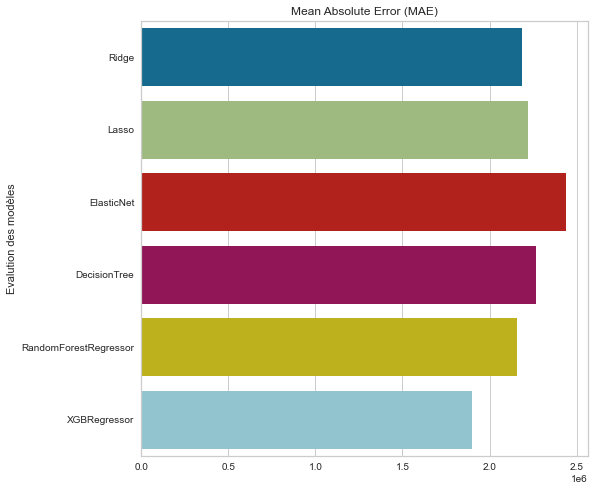

In [55]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Mean Absolute Error (MAE)")
ax.set_ylabel("Evalution des modèles")
ax = sns.barplot(y=list(update_Model_result_gridSearch['model']),
                 x= update_Model_result_gridSearch['MAE'].values.flatten(),
                 data=update_Model_result_gridSearch)


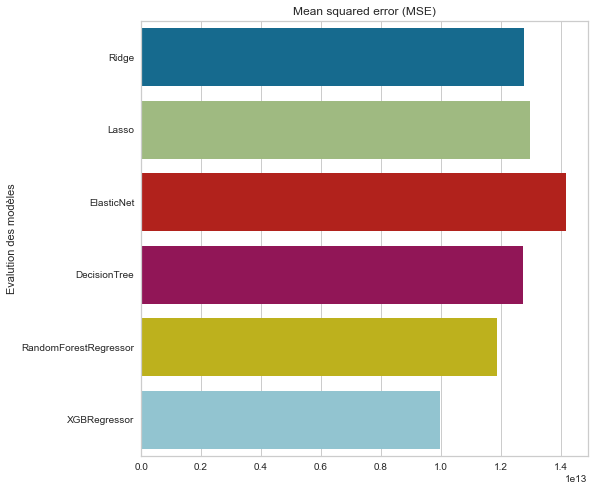

In [56]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Mean squared error (MSE)")
ax.set_ylabel("Evalution des modèles")
ax = sns.barplot(y=list(update_Model_result_gridSearch['model']),
                 x= update_Model_result_gridSearch['MSE'].values.flatten(),
                 data=update_Model_result_gridSearch)

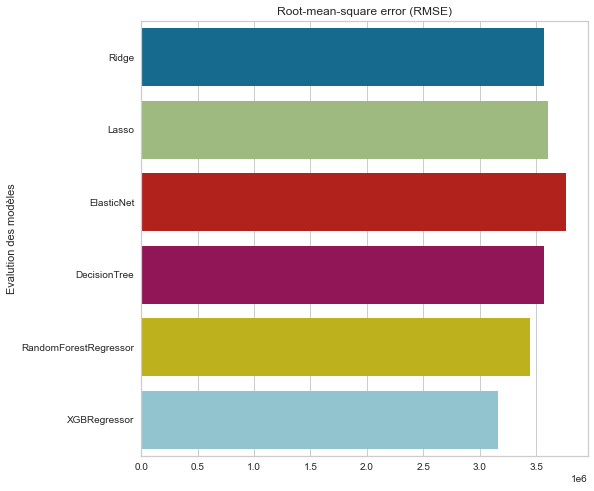

In [57]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Root-mean-square error (RMSE)")
ax.set_ylabel("Evalution des modèles")
ax = sns.barplot(y=list(update_Model_result_gridSearch['model']),
                 x= update_Model_result_gridSearch['RMSE'].values.flatten(),
                 data=update_Model_result_gridSearch)


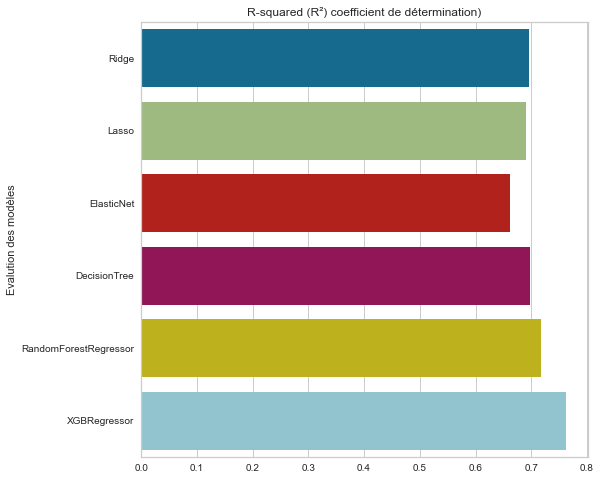

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("R-squared (R²) coefficient de détermination)")
ax.set_ylabel("Evalution des modèles")
ax = sns.barplot(y=list(update_Model_result_gridSearch['model']),
                 x= update_Model_result_gridSearch['R²'].values.flatten(),
                 data=update_Model_result_gridSearch)


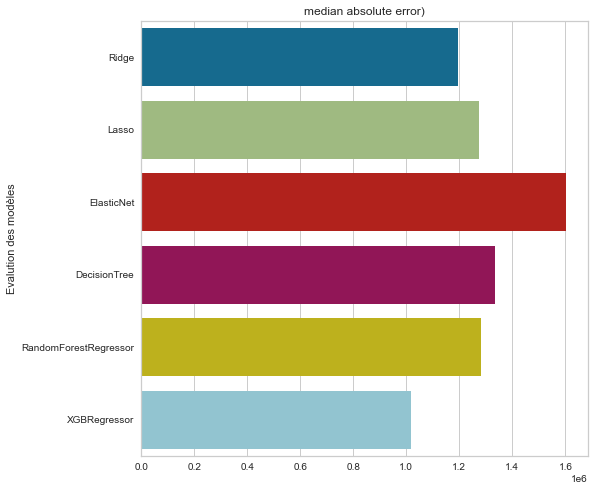

In [59]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("median absolute error)")
ax.set_ylabel("Evalution des modèles")
ax = sns.barplot(y=list(update_Model_result_gridSearch['model']),
                 x= update_Model_result_gridSearch['median abs err'].values.flatten(),
                 data=update_Model_result_gridSearch)


# Comparer les models avec best params
Maintenant on va tester 2 modèles a été choisi avec des bestes paramètres qu'on a trouvé afin d'avoir les meilleurs performances des modèles.

In [139]:
RFR_result_gridSearch_best = []

model = make_pipeline(preprocessor,RandomForestRegressor())

parameters_RFR_best = {'randomforestregressor__bootstrap': [True],
                       'randomforestregressor__max_depth': [5],
                       'randomforestregressor__max_features': [None],
                       'randomforestregressor__min_samples_leaf': [3],
                       'randomforestregressor__n_estimators': [100],
                       'randomforestregressor__criterion': ['squared_error']
                       }

RFR_gridSearch_best = GridSearchCV(model, parameters_RFR_best, cv=5, n_jobs = 5)

RFR_gridSearch_best.fit(X_train, y_train.values.ravel())
y_pred_best = RFR_gridSearch_best.predict(X_test)

mae = mean_absolute_error(y_test,y_pred_best).round(3)
mse = mean_squared_error(y_test,y_pred_best).round(3)
r_score = r2_score(y_test, y_pred_best, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_best)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_best).round(3)

RFR_result_gridSearch_best.append(['RandomForestRegressor',
                          RFR_gridSearch_best.best_score_.round(3),
                          RFR_gridSearch_best.cv_results_['mean_test_score'].round(3),
                          #RFR_gridSearch_best.cv_results_['mean_train_score'].round(3),
                          RFR_gridSearch_best.cv_results_['mean_score_time'].round(3),
                          RFR_gridSearch_best.cv_results_['mean_fit_time'].round(3),
                          mae, mse, rmse, r_score, med_abs_err])

RFR_best_result_gridSearch = pd.DataFrame(RFR_result_gridSearch_best,columns=['model', 'best score', 'mean_test_score','mean_score_time', 'mean_fit_time','MAE', 'MSE', 'RMSE', 'R²', 'median abs err'])
RFR_best_result_gridSearch


,model,best score,mean_test_score,mean_score_time,mean_fit_time,MAE,MSE,RMSE,R²,median abs err
0,RandomForestRegressor,0.593,[0.593],[0.012],[0.472],2084374.083,1.139871e+13,3376197.603,0.729,1174822.679


In [140]:
XGB_result_gridSearch_best = []
model = make_pipeline(preprocessor,XGBRegressor())
parameters_XGB_best= {'xgbregressor__learning_rate': [0.05],
                     'xgbregressor__max_depth': [4], 
                     'xgbregressor__min_child_weight': [4], 
                     'xgbregressor__n_estimators': [200]}

XGB_GridSearch_best = GridSearchCV(model,parameters_XGB_best, cv=5, n_jobs = 5)
XGB_GridSearch_best.fit(X_train, y_train)
y_pred_best = XGB_GridSearch_best.predict(X_test)

mae = mean_absolute_error(y_test,y_pred_best).round(3)
mse = mean_squared_error(y_test,y_pred_best).round(3)
r_score = r2_score(y_test, y_pred_best, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_best)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_best).round(3)
 
XGB_result_gridSearch_best.append(['XGBRegressor',
                          XGB_GridSearch_best.best_score_.round(3),
                          XGB_GridSearch_best.cv_results_['mean_test_score'].round(3),
                          XGB_GridSearch_best.cv_results_['mean_score_time'].round(3),
                          XGB_GridSearch_best.cv_results_['mean_fit_time'].round(3),
                          mae, mse, rmse, r_score, med_abs_err ])

XGB_best_result_gridSearch = pd.DataFrame(XGB_result_gridSearch_best, columns=['model', 'best score', 'mean_test_score','mean_score_time', 'mean_fit_time','MAE', 'MSE', 'RMSE', 'R²', 'median abs err'])
XGB_best_result_gridSearch

,model,best score,mean_test_score,mean_score_time,mean_fit_time,MAE,MSE,RMSE,R²,median abs err
0,XGBRegressor,0.646,[0.646],[0.01],[2.618],1848758.744,9.762449e+12,3124491.833,0.768,938759.812


In [141]:

best_result_gridSearch= pd.concat([RFR_best_result_gridSearch,XGB_best_result_gridSearch], join="outer",ignore_index=True,
                                            verify_integrity=True)
best_result_gridSearch

,model,best score,mean_test_score,mean_score_time,mean_fit_time,MAE,MSE,RMSE,R²,median abs err
0,RandomForestRegressor,0.593,[0.593],[0.012],[0.472],2084374.083,1.139871e+13,3376197.603,0.729,1174822.679
1,XGBRegressor,0.646,[0.646],[0.01],[2.618],1848758.744,9.762449e+12,3124491.833,0.768,938759.812


# Test des modèles sélectionnés avec des best parameters et les métriques de scoring (R2, MAE,RMSE)

In [142]:
# Fonction d'évaluation des modèles de régression
def model_regression_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    print("MAE: ",mae.round(5))
    print("RMSE: ", rmse)
    print("R²: ", r_score.round(5))

In [143]:
final_model_RFR = RFR_gridSearch_best.best_estimator_
final_model_XGB = XGB_GridSearch_best.best_estimator_

final_prediction_RFR = final_model_RFR.predict(X_test)
final_prediction_XGB = final_model_XGB.predict(X_test)
print('final model RandomForest')
model_regression_metrics(np.array(y_test), final_prediction_RFR)
print('-'*50)
print('final model XGBOOST')
model_regression_metrics(np.array(y_test), final_prediction_XGB)

final model RandomForest
MAE:  2084374.0832
RMSE:  3124491.8334950153
R²:  0.72869
--------------------------------------------------
final model XGBOOST
MAE:  1848758.744
RMSE:  3124491.8334950153
R²:  0.76764


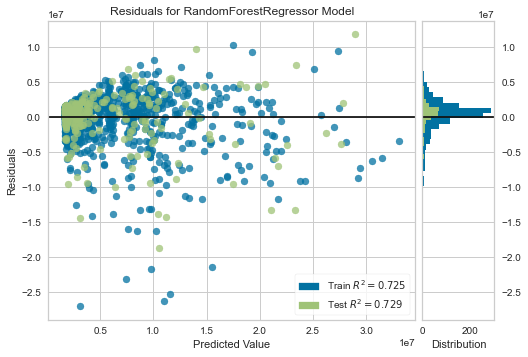

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [144]:
from yellowbrick.regressor import PredictionError, ResidualsPlot

visualizer = ResidualsPlot(final_model_RFR)
visualizer.fit(X_train, np.array(y_train).reshape(1284,)) 
visualizer.score(X_test, y_test)        
visualizer.show()            


La différence entre le coefficient de détermination du jeu d'entraînement et du jeu de test montre qu'il y a overfitting de notre modèle malgré les précautions prises validation croisée, contrainte du modèle en utilisant les paramètres. Modèle RandomForestRegressor permet d'expliquer 73% de la variance expliquée

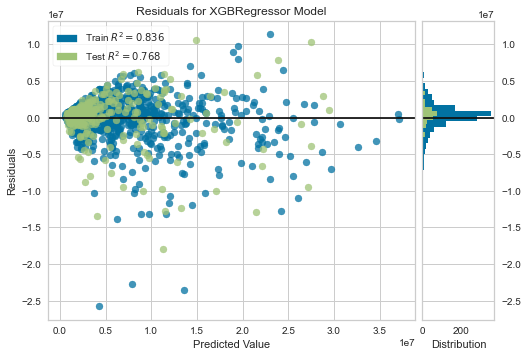

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [146]:
visualizer = ResidualsPlot(final_model_XGB)
visualizer.fit(X_train, np.array(y_train).reshape(1284,)) 
visualizer.score(X_test, y_test)        
visualizer.show() 

Les distributions des résidus du jeu d'entraînement et du jeu de test semblent ne suivre pas une loi normale.
Puisque le nombre de données moins importants (seulement 20% de l'échantillon) on voit que la distribution des résidus du jeu de test est plus aplatie.

La différence entre le coefficient de détermination du jeu d'entraînement et du jeu de test montre qu'il y a overfitting de notre modèle malgré les précautions prises validation croisée, contrainte du modèle en utilisant les paramètres. Modèle XGBOOST permet d'expliquer 86% de la variance expliquée mais les autres indicateurs de performances sont moins bons que pour la prédiction de la consommation d'énergie

### Affichage des valeurs prédites vs valeurs réélles pour consomation d'énrgie 
Nous allons vérifier la distribution des valaurs prédites en fonction des valeurs réélles :

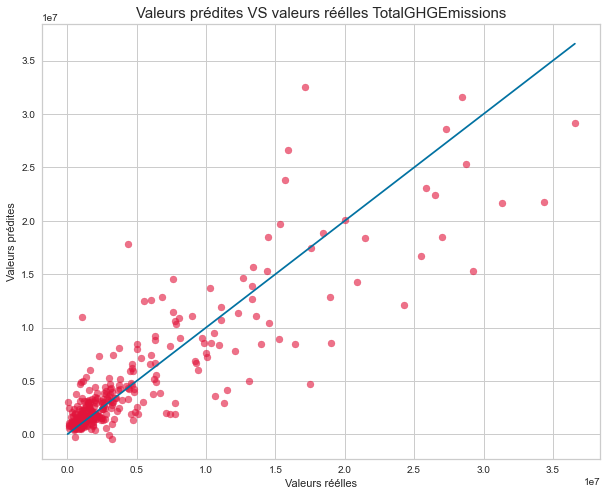

In [147]:

X_plot = [y_test.min(), y_test.max()]
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test, y_pred, color="#e1143b", alpha=.6)
plt.plot(X_plot, X_plot)
plt.xlabel("Valeurs réélles")
plt.ylabel("Valeurs prédites")
plt.title("Valeurs prédites VS valeurs réélles TotalGHGEmissions", fontsize=15)
plt.show()

Les valeurs prédites sont pas très éloignées de la première bissectrice. 

# la feature importance

L'importance de la fonctionnalité (importance variable) décrit les fonctionnalités pertinentes. Cela peut aider à mieux comprendre le problème résolu et parfois conduire à des améliorations du modèle en utilisant la sélection de fonctionnalités. je présenterai une façon de calculer l'importance des fonctionnalités pour l'algorithme Random Forest.

On a 3 façons à calculer:
- Fonctionnalité Importance intégrée à l'algorithme Random Forest,
- Importance des fonctionnalités calculée avec la méthode de permutation,
- Importance des fonctionnalités calculée avec les valeurs SHAP.

On compare les performances_Feature importances avec random forest 



### Feature importance based on mean decrease in impurity

In [35]:
import time
start_time = time.time()
feature_names = [col for col in df_model.columns]
importances = RFR_gridSearch_best.best_estimator_._final_estimator.feature_importances_

Index_cat = RFR_gridSearch_best.best_estimator_.named_steps['columntransformer'].transformers_[0][1]['encoder'].get_feature_names_out()
Index_num = RFR_gridSearch_best.best_estimator_.named_steps['columntransformer'].transformers_[1][1]['scaler'].get_feature_names_out()
Index = np.concatenate((Index_cat, Index_num), axis=0)

forest_importances = pd.Series(importances, index=Index)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.006 seconds


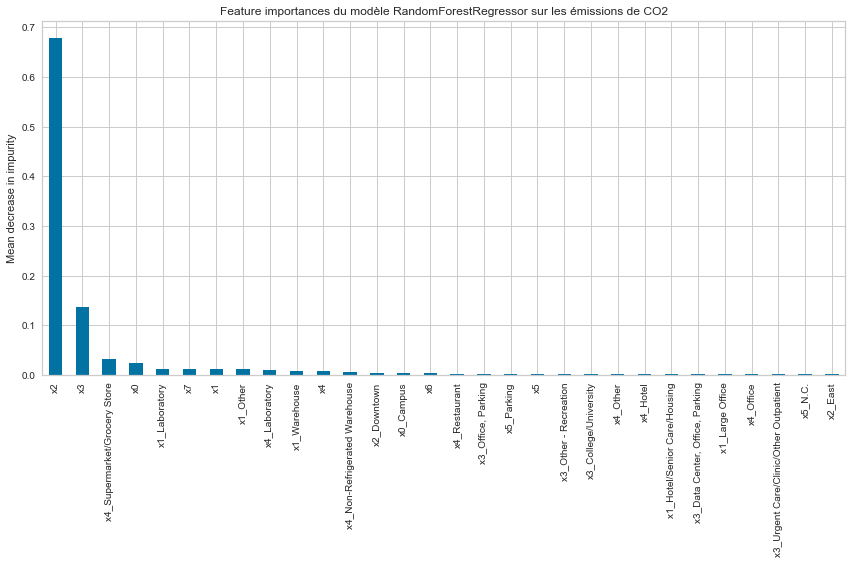

In [37]:
top20_features = forest_importances.nlargest(30)
fig, ax = plt.subplots(figsize=(12,8))
top20_features.plot.bar(ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur les émissions de CO2")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout() 

# Prédiction des émissions de CO2 avec ENERGY STAR SCORE
on va regarder si l'ajout du score ENERGY STAR va permettre d'améliorer notre modèle

In [38]:
energy_star_score

,ENERGYSTARScore
0,91.0
1,45.0
2,59.0
3,76.0
4,86.0
...,...
1633,46.0
1634,NaN
1635,NaN
1636,NaN


In [39]:
#Ajout de la variable à nos variables X
X['Energy_star_score'] = energy_star_score

#Ajout de la variable dans les variables numérique du preprocessor
num_var.append('energy_star_score')

#Filtrage des données ayant un Energy Star Score renseigné
X = X[X['Energy_star_score'].isnull()==False]
y = y[y.index.isin(list(X.index))]


In [40]:
# Séparation des variables catégorielles et numériques
cat_var = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood','ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']
num_var = ['Latitude', 'Longitude', 'PropertyGFATotal','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
        'GFABuildingRate', 'GFAParkingRate', 'Age', 'Energy_star_score']

In [41]:
# Création d'un pipeline de transformation
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[('cat', cat_pipe, cat_var),('num', num_pipe, num_var)])

In [42]:
models = {
    'Dummy Regressor' : DummyRegressor(strategy="median"),
    #'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'DecisionTree' : DecisionTreeRegressor(random_state=42),
    'ElasticNet' : ElasticNet(),
    'SVR': SVR(),
    'Ridge Kernel' : KernelRidge(),
    'GradientBoosting' : GradientBoostingRegressor(random_state=42),
    'RandomForestRegressor' : RandomForestRegressor(random_state=42),
    'XGBRegressor' : XGBRegressor()
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [43]:
results_model_eStar = []

for model_name, model in models.items():
    model = make_pipeline(preprocessor,model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluer les performances du modèles avec les métriques
    mae = mean_absolute_error(y_test, y_pred).round(3)
    mse = mean_squared_error(y_test, y_pred).round(3)
    rmse = np.sqrt(mse).round(3)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    med_abs_err = median_absolute_error(y_test,y_pred).round(3)
  
    results_model_eStar.append([model_name, mae.round(3), mse.round(3), rmse.round(3), r_score.round(3), med_abs_err.round(3)])
    
model_score_eval = pd.DataFrame(results_model_eStar,columns=['model', 'MAE', 'MSE', 'RMSE', 'R²', 'median abs err'])
display(model_score_eval.sort_values(by=['RMSE', 'R²', 'MAE'],ascending=False))


,model,MAE,MSE,RMSE,R²,median abs err
0,Dummy Regressor,4087180.112,5.372622e+13,7329817.366,-0.192,1717487.031
5,SVR,4087163.060,5.372593e+13,7329797.655,-0.192,1717478.625
4,ElasticNet,2410747.893,1.513900e+13,3890886.789,0.664,1434004.169
3,DecisionTree,2249527.032,1.423364e+13,3772749.165,0.684,1092317.516
2,Lasso,2183329.232,1.302614e+13,3609174.561,0.711,1206471.707
9,XGBRegressor,1831737.879,1.062237e+13,3259198.393,0.764,830446.219
8,RandomForestRegressor,1742020.193,8.740025e+12,2956353.254,0.806,856907.939
6,Ridge Kernel,1782109.033,8.644298e+12,2940118.664,0.808,1048335.030
1,Ridge,1776676.224,8.521861e+12,2919222.628,0.811,1054094.195
7,GradientBoosting,1608421.059,7.915886e+12,2813518.486,0.824,720164.510


On va comparer les modèles en précisant des paramétres

In [44]:
results_gridSearch_eStar = []

# model Ridge
model = make_pipeline(preprocessor,Ridge())
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)
parameters_Ridge = {'ridge__alpha':alphas,
              'ridge__fit_intercept' :[True,False], 
              'ridge__copy_X':[True, False],}

Ridge_gridSearch = GridSearchCV(model,parameters_Ridge, cv=5, n_jobs = 5)

Ridge_gridSearch.fit(X_train, y_train.values.ravel())
y_pred_Ridge = Ridge_gridSearch.predict(X_test)

print('Best score et params Ridge')
print ("best score: ", Ridge_gridSearch.best_score_)
print("best params: ",Ridge_gridSearch.best_params_)
mae = mean_absolute_error(y_test,y_pred_Ridge).round(3)
mse = mean_squared_error(y_test,y_pred_Ridge).round(3)
r_score = r2_score(y_test, y_pred_Ridge, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_Ridge)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_Ridge).round(3)

results_gridSearch_eStar.append(['Ridge',
                          Ridge_gridSearch.best_score_,
                          Ridge_gridSearch.best_params_,
                          Ridge_gridSearch.cv_results_['mean_test_score'],
                          Ridge_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])

Best score et params Ridge
best score:  0.745295596480886
best params:  {'ridge__alpha': 3.593813663804626, 'ridge__copy_X': True, 'ridge__fit_intercept': True}


In [45]:
# Model Lasso
model = make_pipeline(preprocessor,Lasso(tol=0.5))
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)
parameters_Lasso = {'lasso__alpha':alphas }
Lasso_gridSearch = GridSearchCV(model,parameters_Lasso, cv=5, n_jobs = 5)
Lasso_gridSearch.fit(X_train, y_train)
y_pred_Lasso = Lasso_gridSearch.predict(X_test)
print('Best score et params Lasso')
print ("best score: ", Lasso_gridSearch.best_score_)
print("best params: ",Lasso_gridSearch.best_params_)
mae = mean_absolute_error(y_test,y_pred_Lasso).round(3)
mse = mean_squared_error(y_test,y_pred_Lasso).round(3)
r_score = r2_score(y_test, y_pred_Lasso, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_Lasso)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_Lasso).round(3)


results_gridSearch_eStar.append(['Lasso',
                          Lasso_gridSearch.best_score_,
                          Lasso_gridSearch.best_params_,
                          Lasso_gridSearch.cv_results_['mean_test_score'],
                          Lasso_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])

Best score et params Lasso
best score:  0.684299356219955
best params:  {'lasso__alpha': 100000.0}


In [46]:
# model ElasticNet
model = make_pipeline(preprocessor,ElasticNet(max_iter=10000,tol=100))
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)
l1_ratio = np.logspace(-5, 1, n_alphas)
parameters_eNet = {"elasticnet__max_iter": [50, 100, 1000],
                   "elasticnet__alpha":alphas, 
                   "elasticnet__l1_ratio":l1_ratio}

eNet_gridSearch = GridSearchCV(model,parameters_eNet, cv=5, n_jobs = 5)
eNet_gridSearch.fit(X_train, y_train)
y_pred_eNet = eNet_gridSearch.predict(X_test)

print('Best score et params ElasticNet')
print ("best score: ", eNet_gridSearch.best_score_)
print("best params: ",eNet_gridSearch.best_params_)
mae = mean_absolute_error(y_test,y_pred_eNet).round(3)
mse = mean_squared_error(y_test,y_pred_eNet).round(3)
r_score = r2_score(y_test, y_pred_eNet, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_eNet)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_eNet).round(3)


results_gridSearch_eStar.append(['ElasticNet',
                          eNet_gridSearch.best_score_,
                          eNet_gridSearch.best_params_,
                          eNet_gridSearch.cv_results_['mean_test_score'],
                          eNet_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])

Best score et params ElasticNet
best score:  0.6749983265604048
best params:  {'elasticnet__alpha': 0.2782559402207126, 'elasticnet__l1_ratio': 1e-05, 'elasticnet__max_iter': 50}


In [47]:
# Model DecisionTreeRegressor
model = make_pipeline(preprocessor,DecisionTreeRegressor(random_state=42))

parameters_DTR = {"decisiontreeregressor__max_features" : ['sqrt', 'log2', None],
                  "decisiontreeregressor__max_depth" : [1, 2, 3, 4, 5],
                  "decisiontreeregressor__min_samples_leaf" : [1, 2, 3]}

DTR_gridSearch = GridSearchCV(model, parameters_DTR, cv=5, n_jobs = 5)

DTR_gridSearch.fit(X_train, y_train.values.ravel())
y_pred_DTR = DTR_gridSearch.predict(X_test)

print('Best score et params DecisionTree')
print ("best score: ", DTR_gridSearch.best_score_)
print("best params: ",DTR_gridSearch.best_params_)
mae = mean_absolute_error(y_test,y_pred_DTR).round(3)
mse = mean_squared_error(y_test,y_pred_DTR).round(3)
r_score = r2_score(y_test, y_pred_DTR, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_DTR)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_DTR).round(3)


results_gridSearch_eStar.append(['DecisionTree',
                          DTR_gridSearch.best_score_,
                          DTR_gridSearch.best_params_,
                          DTR_gridSearch.cv_results_['mean_test_score'],
                          DTR_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])

Best score et params DecisionTree
best score:  0.6305393850214707
best params:  {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__min_samples_leaf': 1}


In [48]:
# model RandomForestRegressor
model = make_pipeline(preprocessor,RandomForestRegressor())

parameters_RFR = {"randomforestregressor__n_estimators": [100, 200, 300],
                  "randomforestregressor__bootstrap":[True],
                  "randomforestregressor__max_features" : ['sqrt', 'log2', None],
                  "randomforestregressor__max_depth" : [1, 2, 3, 4, 5],
                  "randomforestregressor__criterion" : ['squared_error', 'absolute_error'],
                  "randomforestregressor__min_samples_leaf" : [1, 2, 3]}

RFR_gridSearch = GridSearchCV(model, parameters_RFR, cv=5, n_jobs = 5)

RFR_gridSearch.fit(X_train, y_train.values.ravel())
y_pred_RFR = RFR_gridSearch.predict(X_test)

print('Best score et params RandomForestRegressor')
print ("best score: ", RFR_gridSearch.best_score_)
print("best params: ",RFR_gridSearch.best_params_)

mae = mean_absolute_error(y_test,y_pred_RFR).round(3)
mse = mean_squared_error(y_test,y_pred_RFR).round(3)
r_score = r2_score(y_test, y_pred_RFR, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_RFR)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_RFR).round(3)


results_gridSearch_eStar.append(['RandomForestRegressor',
                          RFR_gridSearch.best_score_,
                          RFR_gridSearch.best_params_,
                          RFR_gridSearch.cv_results_['mean_test_score'],
                          RFR_gridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err])



Best score et params RandomForestRegressor
best score:  0.7472870227122048
best params:  {'randomforestregressor__bootstrap': True, 'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 100}


In [49]:
# model XGBOOST
model = make_pipeline(preprocessor,XGBRegressor())
parameters_XGB= {'xgbregressor__learning_rate': [0.05, 0.08, 0.01, 0.1],
                 'xgbregressor__max_depth': [ 2, 3, 4, 5, 6, 7, 8,10],
                 'xgbregressor__min_child_weight': [4, 5],
                 'xgbregressor__n_estimators': [100, 200, 500, 1000],
                }

XGB_GridSearch = GridSearchCV(model,parameters_XGB, cv=5, n_jobs = 5)
XGB_GridSearch.fit(X_train, y_train)
y_pred_XGB = XGB_GridSearch.predict(X_test)
           

mae = mean_absolute_error(y_test,y_pred_XGB).round(3)
mse = mean_squared_error(y_test,y_pred_XGB).round(3)
r_score = r2_score(y_test, y_pred_XGB, multioutput="variance_weighted").round(3)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_XGB)).round(3)
med_abs_err = median_absolute_error(y_test,y_pred_XGB).round(3)
print('Best score et params XGBRegressor ')
print ("best score: ", XGB_GridSearch.best_score_)
print("best params: ",XGB_GridSearch.best_params_)

results_gridSearch_eStar.append(['XGBRegressor',
                          XGB_GridSearch.best_score_,
                          XGB_GridSearch.best_params_,
                          XGB_GridSearch.cv_results_['mean_test_score'],
                          XGB_GridSearch.cv_results_['mean_score_time'],
                          mae, mse, rmse, r_score, med_abs_err ])

Best score et params XGBRegressor 
best score:  0.80705160289735
best params:  {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 2, 'xgbregressor__min_child_weight': 5, 'xgbregressor__n_estimators': 1000}


# Conclusion

In [72]:
Model_result_gridSearch_eStar = pd.DataFrame(results_gridSearch_eStar,columns=['model', 'best_score', 'best_params','mean_test_score','mean_score_time','MAE', 'MSE', 'RMSE', 'R²', 'median abs err'])

print("Sans le EnergyStarScore:")
update_Model_result_gridSearch2 = update_Model_result_gridSearch.drop(['best_params', 'mean_test_score', 'mean_score_time'], axis=1)
display(update_Model_result_gridSearch2.sort_values(by=['best_score','RMSE'],ascending=False))

print("Avec  le EnergyStarScore:")
Model_result_gridSearch_eStar = Model_result_gridSearch_eStar.drop(['best_params', 'mean_test_score', 'mean_score_time'], axis=1)
display(Model_result_gridSearch_eStar.sort_values(by=['best_score','RMSE'],ascending=False))



Sans le EnergyStarScore:


,model,best_score,MAE,MSE,RMSE,R²,median abs err
6,XGBRegressor,0.653669,1898797.729,9.970768e+12,3157652.348,0.763,1015940.000
1,Ridge,0.649723,2185841.789,1.276844e+13,3573295.912,0.696,1194681.702
2,Lasso,0.612418,2223006.586,1.296480e+13,3600666.356,0.691,1273741.727
5,RandomForestRegressor,0.607108,2155296.169,1.189030e+13,3448232.004,0.717,1283422.783
3,ElasticNet,0.563065,2440616.382,1.419283e+13,3767336.608,0.662,1603599.745
4,DecisionTree,0.484125,2265857.068,1.274568e+13,3570109.299,0.697,1335396.713


Avec  le EnergyStarScore:


,model,best_score,MAE,MSE,RMSE,R²,median abs err
5,XGBRegressor,0.807052,1659881.867,7.699116e+12,2774728.149,0.829,844579.781
4,RandomForestRegressor,0.747287,2054568.838,1.071013e+13,3272634.210,0.762,1122091.520
0,Ridge,0.745296,1780328.842,8.755140e+12,2958908.642,0.806,1053926.537
1,Lasso,0.684299,2167623.538,1.266136e+13,3558279.964,0.719,1234265.376
2,ElasticNet,0.674998,2403790.810,1.440922e+13,3795948.380,0.680,1353631.134
3,DecisionTree,0.630539,2436344.641,1.525254e+13,3905450.062,0.662,1173002.935


### Model RandonForest Regressor avec ENERGY STAR SCORE et best paramètres

In [51]:
# Recherche de la meilleure configuration d'hyperparamètre
RFR_result_gridSearch_eStar = []

model = make_pipeline(preprocessor,RandomForestRegressor())

parameters_RFR_eStar = {'randomforestregressor__bootstrap': [True],
                       'randomforestregressor__max_depth': [5],
                       'randomforestregressor__max_features': [None],
                       'randomforestregressor__min_samples_leaf': [3],
                       'randomforestregressor__n_estimators': [100],
                       'randomforestregressor__criterion': ['squared_error']}

RFR_gridSearch_eStar = GridSearchCV(model, parameters_RFR_best, cv=5, n_jobs = -1)

RFR_gridSearch_eStar.fit(X_train, y_train.values.ravel())
y_pred_eStar = RFR_gridSearch_eStar.predict(X_test)

RFR_result_gridSearch_eStar.append(['RandomForestRegressor',
                          RFR_gridSearch_eStar.best_score_.round(3),
                          RFR_gridSearch_eStar.cv_results_['mean_test_score'].round(3),
                          #RFR_gridSearch_best.cv_results_['mean_train_score'].round(3),
                          RFR_gridSearch_eStar.cv_results_['mean_score_time'].round(3),
                          RFR_gridSearch_eStar.cv_results_['mean_fit_time'].round(3),
                          mean_absolute_error(y_test,y_pred_eStar).round(3),
                          mean_squared_error(y_test, y_pred_eStar).round(3),
                          np.sqrt(mean_squared_error(y_test,y_pred_eStar)).round(3),
                          r2_score(y_test, y_pred_eStar).round(3),
                          median_absolute_error(y_test,y_pred_eStar).round(3) ])

RFR_result_gridSearch_eStar = pd.DataFrame(RFR_result_gridSearch_eStar,columns=['model', 'best score', 'mean_test_score','mean_score_time','mean_fit_time', 'RMSE', 'MSE', 'MAE', 'R²', 'median abs err'])
RFR_result_gridSearch_eStar

,model,best score,mean_test_score,mean_score_time,mean_fit_time,RMSE,MSE,MAE,R²,median abs err
0,RandomForestRegressor,0.733,[0.733],[0.011],[0.369],2027130.405,1.072061e+13,3274233.733,0.762,1138645.418


### Model XGBOOST avec ENERGY STAR SCORE et best paramètres

In [52]:
XGB_result_gridSearch_eStar = []
model = make_pipeline(preprocessor,XGBRegressor())
parameters_XGB_eStar= {'xgbregressor__learning_rate': [0.05],
                     'xgbregressor__max_depth': [4], 
                     'xgbregressor__min_child_weight': [4], 
                     'xgbregressor__n_estimators': [200]}

XGB_GridSearch_eStar = GridSearchCV(model,parameters_XGB_best, cv=5, n_jobs = -1)
XGB_GridSearch_eStar.fit(X_train, y_train)
y_pred_eStar = XGB_GridSearch_eStar.predict(X_test)
 
XGB_result_gridSearch_eStar.append(['XGBRegressor',
                          XGB_GridSearch_eStar.best_score_.round(3),
                          XGB_GridSearch_eStar.cv_results_['mean_test_score'].round(3),
                          XGB_GridSearch_eStar.cv_results_['mean_score_time'].round(3),
                          XGB_GridSearch_eStar.cv_results_['mean_fit_time'].round(3),
                          #XGB_GridSearch_eStar.cv_results_['mean_train_score'].round(3),
                          mean_absolute_error(y_test,y_pred_eStar).round(3),
                          mean_squared_error(y_test, y_pred_eStar).round(3),
                          np.sqrt(mean_squared_error(y_test,y_pred_eStar)).round(3),
                          r2_score(y_test, y_pred_eStar).round(3),
                          median_absolute_error(y_test,y_pred_eStar).round(3) ])

XGB_result_gridSearch_eStar = pd.DataFrame(XGB_result_gridSearch_eStar,columns=['model', 'best score', 'mean_test_score','mean_score_time','mean_fit_time', 'RMSE', 'MSE', 'MAE', 'R²', 'median abs err'])
XGB_result_gridSearch_eStar

,model,best score,mean_test_score,mean_score_time,mean_fit_time,RMSE,MSE,MAE,R²,median abs err
0,XGBRegressor,0.792,[0.792],[0.007],[0.921],1705698.938,8.794062e+12,2965478.449,0.805,758526.75


In [53]:
result_gridSearch_eStar= pd.concat([RFR_result_gridSearch_eStar,XGB_result_gridSearch_eStar], join="outer",ignore_index=True,
                                            verify_integrity=True)
result_gridSearch_eStar

,model,best score,mean_test_score,mean_score_time,mean_fit_time,RMSE,MSE,MAE,R²,median abs err
0,RandomForestRegressor,0.733,[0.733],[0.011],[0.369],2027130.405,1.072061e+13,3274233.733,0.762,1138645.418
1,XGBRegressor,0.792,[0.792],[0.007],[0.921],1705698.938,8.794062e+12,2965478.449,0.805,758526.750


## Comparer les deux model avec best parametres pour deux dataframe avec et sans Energy star score

In [54]:

compare_model_with_without_eStar= pd.concat([best_result_gridSearch,result_gridSearch_eStar], join="outer",
                                            ignore_index=True, keys=['Sans ENERGY STAR', 'Avec ENERGY STAR'])

compare_model_with_without_eStar.insert(2, "column Energy star", ('False', 'False','True','True') , allow_duplicates=True)
compare_model_with_without_eStar

,model,best score,column Energy star,mean_test_score,mean_score_time,mean_fit_time,RMSE,MSE,MAE,R²,median abs err
0,RandomForestRegressor,0.589,False,[0.589],[0.012],[0.475],2086024.764,1.128893e+13,3359899.727,0.731,1200388.301
1,XGBRegressor,0.646,False,[0.646],[0.019],[2.735],1848758.744,9.762449e+12,3124491.833,0.768,938759.812
2,RandomForestRegressor,0.733,True,[0.733],[0.011],[0.369],2027130.405,1.072061e+13,3274233.733,0.762,1138645.418
3,XGBRegressor,0.792,True,[0.792],[0.007],[0.921],1705698.938,8.794062e+12,2965478.449,0.805,758526.750


 Ces modèles peuvent être utilisés pour nos prédictions mais il faudra prendre en compte que les erreurs sont plus importantes que pour la consommation d'énergie d'un bâtiment. 

L'ajout d'une variable supplémentaire comme le score Energy Star ne va pas modifier les scores de la prédiction
